[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahdimplus/DeepRetroMoco/blob/main/network/train_with_validtiondatafunctions.ipynb)

In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/data/data selection_D1")
#data_dir="drive/My Drive/data/data selection_D1"

In [3]:
data_dir="drive/My Drive/data/data selection_D1"

In [4]:
ls

DeepRetroMoco/     S09_RS_PRE.nii.gz  S17_RS_MSL.nii.gz  S24_RND.nii.gz
S02_MSL.nii.gz     S09_RS_RND.nii.gz  S17_RS_PRE.nii.gz  S24_RS_MSL.nii.gz
S02_RND.nii.gz     S10_MSL.nii.gz     S17_RS_RND.nii.gz  S24_RS_PRE.nii.gz
S02_RS_MSL.nii.gz  S10_RND.nii.gz     S18_MSL.nii.gz     S24_RS_RND.nii.gz
S02_RS_PRE.nii.gz  S10_RS_MSL.nii.gz  S18_RND.nii.gz     S25_MSL.nii.gz
S02_RS_RND.nii.gz  S10_RS_PRE.nii.gz  S18_RS_MSL.nii.gz  S25_RND.nii.gz
S03_MSL.nii.gz     S10_RS_RND.nii.gz  S18_RS_PRE.nii.gz  S25_RS_MSL.nii.gz
S03_RND.nii.gz     S11_MSL.nii.gz     S18_RS_RND.nii.gz  S25_RS_PRE.nii.gz
S03_RS_MSL.nii.gz  S11_RND.nii.gz     S19_MSL.nii.gz     S25_RS_RND.nii.gz
S03_RS_PRE.nii.gz  S11_RS_MSL.nii.gz  S19_RND.nii.gz     S26_MSL.nii.gz
S03_RS_RND.nii.gz  S11_RS_PRE.nii.gz  S19_RS_MSL.nii.gz  S26_RND.nii.gz
S04_MSL.nii.gz     S11_RS_RND.nii.gz  S19_RS_PRE.nii.gz  S26_RS_MSL.nii.gz
S04_RND.nii.gz     S12_MSL.nii.gz     S19_RS_RND.nii.gz  S26_RS_PRE.nii.gz
S04_RS_MSL.nii.gz  S12_RND.nii.gz     S2

In [6]:
pip install voxelmorph


     |████████████████████████████████| 75 kB 3.0 MB/s 
     |████████████████████████████████| 86 kB 6.8 MB/s 


In [19]:
!pip install nbimporter

In [20]:
# imports
# local imports
import voxelmorph as vxm
import neurite as ne
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'
import matplotlib.pyplot as plt
import cv2

%matplotlib inline
import nibabel as nib

#import nbimporter
#from functions import *


In [ ]:
data_dir='/home/mahdi/Desktop/data_selection_D7'

In [8]:
#m=maxx(data_dir)
m=1584 

In [9]:
import random
def load_m (file_path):
    
    img = nib.load(file_path)
    img_data = img.get_fdata()
    
    if img.shape[0:2]!=(64,64):
    
        img_data = img_data[23:87,23:87,:,:]
        
    if not (file_path.endswith(".nii") or file_path.endswith(".nii.gz")):
        raise ValueError(
              f"Nifti file path must end with .nii or .nii.gz, got {file_path}."
                        )
    return img_data 
def count (data_dir):
    train_dir = os.path.join(data_dir)

    train_data_num = []
    for file in os.listdir(train_dir):
            train_data_num.append([file])
    train_data_num=np.array(train_data_num) 
    n=train_data_num.shape[0] 

    return n,train_data_num

In [10]:
def data_generator(data_dir, batch_size,m,split):
    """4
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    
    m= maximum between all subject 
    split= percent of validation data
    
    
    """
    
    n,train_data_num=count(data_dir)
    n_train=n-int(split*n)
 
    
    subject_ID=random.randint(0,n_train-1)
    d=load_m(data_dir+'/'+str(train_data_num[subject_ID][0]))

    
    s=d.shape[2]
    slice_ID =random.randint(0,s-1)
    v=d.shape[3]
    
 # preliminary sizing
    vol_shape = d.shape[:2] # extract data shape
    ndims = len(vol_shape)
    
    
    d=d[:,:,slice_ID,:]
    d = np.einsum('jki->ijk', d)

    
    
   
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, v, size=batch_size)
        moving_images = d[idx1, ..., np.newaxis]
        moving_images=moving_images/m
        
        idx2 = np.random.randint(0, v, size=batch_size)
        fixed_images = d[idx2, ..., np.newaxis]
        fixed_images=fixed_images/m
        
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [14]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
data_dir='/content/drive/MyDrive/data/data selection_D1'

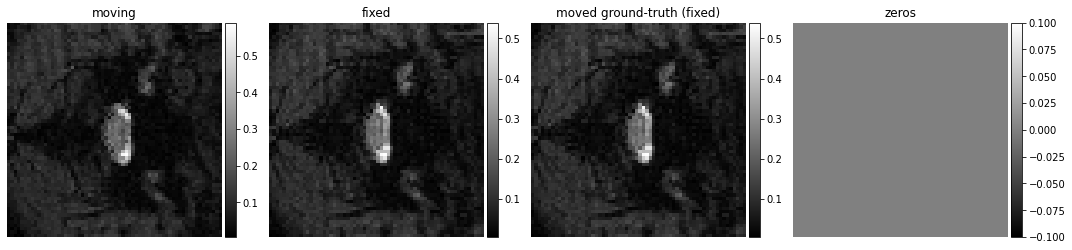

In [21]:
split=0.3  # it means 70% for train and 30% for validation


train_generator = data_generator(data_dir,100,m,split)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);


In [22]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
# data shape 64*64
s=in_sample[0].shape[1:3]
inshape = (*s, unet_input_features)

# configure unet features 
nb_features = [
    [64, 64, 64, 64],         # encoder features
    [64, 64, 64, 64, 64, 32,16]  # decoder features
]

In [23]:
s

(64, 64)

In [24]:
# build model using VxmDense
inshape =s
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

Instructions for updating:
Use fn_output_signature instead


In [25]:
vxm_model.summary()

Model: "vxm_dense"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 source_input (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 target_input (InputLayer)      [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 unet_input_concat (Concatenate  (None, 64, 64, 2)   0           ['source_input[0][0]',           
 )                                                                'target_input[0][0]']           
                                                                                                  
 unet_enc_conv_0_0 (Conv2D)     (None, 64, 64, 64)   1216        ['unet_input_concat[0][0]

In [26]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0
loss_weights = [1, lambda_param]

In [27]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights, metrics=['accuracy'])

In [28]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=5, verbose=1)
#annealer = ReduceLROnPlateau(monitor=['val_accuracy','val_mse'] ,factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [ ]:
nb_epochs =200
steps_per_epoch =100
hist = vxm_model.fit(train_generator,
                               epochs=nb_epochs,
                               steps_per_epoch=steps_per_epoch,
                               verbose=2,
                               callbacks=[es,checkpoint],
                               validation_data=val_generator(data_dir,1,1584,.3)
                    );

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.00076, saving model to model.h5
100/100 - 435s - loss: 0.0011 - transformer_loss: 0.0011 - flow_loss: 0.0012 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.0607 - val_loss: 7.5929e-04 - val_transformer_loss: 7.3158e-04 - val_flow_loss: 0.0028 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 0.0000e+00
Epoch 2/200

Epoch 00002: val_loss did not improve from 0.00076
100/100 - 476s - loss: 6.9619e-04 - transformer_loss: 6.6173e-04 - flow_loss: 0.0034 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.3390 - val_loss: 8.3998e-04 - val_transformer_loss: 8.0592e-04 - val_flow_loss: 0.0034 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 0.0061
Epoch 3/200

Epoch 00003: val_loss improved from 0.00076 to 0.00071, saving model to model.h5
100/100 - 485s - loss: 6.3073e-04 - transformer_loss: 5.9271e-04 - flow_loss: 0.0038 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.3997 - val_loss: 7.1296e-04 - v

Epoch 14/200

Epoch 00014: val_loss did not improve from 0.00049
100/100 - 469s - loss: 5.3700e-04 - transformer_loss: 4.8095e-04 - flow_loss: 0.0056 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4996 - val_loss: 4.9104e-04 - val_transformer_loss: 4.5049e-04 - val_flow_loss: 0.0041 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 0.0000e+00
Epoch 15/200

Epoch 00015: val_loss did not improve from 0.00049
100/100 - 472s - loss: 5.3350e-04 - transformer_loss: 4.7685e-04 - flow_loss: 0.0057 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5006 - val_loss: 5.1590e-04 - val_transformer_loss: 4.7459e-04 - val_flow_loss: 0.0041 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 0.0000e+00
Epoch 16/200

Epoch 00016: val_loss improved from 0.00049 to 0.00047, saving model to model.h5
100/100 - 474s - loss: 5.3017e-04 - transformer_loss: 4.7267e-04 - flow_loss: 0.0057 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4978 - val_loss: 4.7219e-04 - val_transfor

Epoch 27/200

Epoch 00027: val_loss did not improve from 0.00044
100/100 - 474s - loss: 5.1539e-04 - transformer_loss: 4.5147e-04 - flow_loss: 0.0064 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5079 - val_loss: 4.4944e-04 - val_transformer_loss: 4.0033e-04 - val_flow_loss: 0.0049 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 28/200

Epoch 00028: val_loss improved from 0.00044 to 0.00043, saving model to model.h5
100/100 - 470s - loss: 5.1664e-04 - transformer_loss: 4.5228e-04 - flow_loss: 0.0064 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5073 - val_loss: 4.2804e-04 - val_transformer_loss: 3.7794e-04 - val_flow_loss: 0.0050 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 2.4414e-04
Epoch 29/200

Epoch 00029: val_loss improved from 0.00043 to 0.00042, saving model to model.h5
100/100 - 469s - loss: 5.1266e-04 - transformer_loss: 4.4825e-04 - flow_loss: 0.0064 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5064 - val_l

Epoch 40/200

Epoch 00040: val_loss did not improve from 0.00039
100/100 - 491s - loss: 5.0704e-04 - transformer_loss: 4.3976e-04 - flow_loss: 0.0067 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5080 - val_loss: 4.0268e-04 - val_transformer_loss: 3.5180e-04 - val_flow_loss: 0.0051 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 41/200

Epoch 00041: val_loss did not improve from 0.00039
100/100 - 492s - loss: 5.0283e-04 - transformer_loss: 4.3567e-04 - flow_loss: 0.0067 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5036 - val_loss: 4.0986e-04 - val_transformer_loss: 3.5412e-04 - val_flow_loss: 0.0056 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 42/200

Epoch 00042: val_loss did not improve from 0.00039
100/100 - 490s - loss: 5.0410e-04 - transformer_loss: 4.3668e-04 - flow_loss: 0.0067 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5035 - val_loss: 4.0204e-04 - val_transformer_loss: 3.4980e-04 - val_flo

Epoch 53/200

Epoch 00053: val_loss did not improve from 0.00039
100/100 - 497s - loss: 5.0132e-04 - transformer_loss: 4.3211e-04 - flow_loss: 0.0069 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5022 - val_loss: 3.8654e-04 - val_transformer_loss: 3.3302e-04 - val_flow_loss: 0.0054 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 54/200

Epoch 00054: val_loss did not improve from 0.00039
100/100 - 494s - loss: 4.9824e-04 - transformer_loss: 4.2910e-04 - flow_loss: 0.0069 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5067 - val_loss: 4.1528e-04 - val_transformer_loss: 3.5848e-04 - val_flow_loss: 0.0057 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 55/200

Epoch 00055: val_loss improved from 0.00039 to 0.00038, saving model to model.h5
100/100 - 494s - loss: 4.9734e-04 - transformer_loss: 4.2775e-04 - flow_loss: 0.0070 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5071 - val_loss: 3.7931e-04 - val_transfor

Epoch 66/200

Epoch 00066: val_loss improved from 0.00038 to 0.00037, saving model to model.h5
100/100 - 499s - loss: 4.9567e-04 - transformer_loss: 4.2424e-04 - flow_loss: 0.0071 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4981 - val_loss: 3.7372e-04 - val_transformer_loss: 3.1891e-04 - val_flow_loss: 0.0055 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 9.7656e-04
Epoch 67/200

Epoch 00067: val_loss did not improve from 0.00037
100/100 - 496s - loss: 4.9220e-04 - transformer_loss: 4.2090e-04 - flow_loss: 0.0071 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5078 - val_loss: 3.7641e-04 - val_transformer_loss: 3.2056e-04 - val_flow_loss: 0.0056 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 68/200

Epoch 00068: val_loss did not improve from 0.00037
100/100 - 501s - loss: 4.9500e-04 - transformer_loss: 4.2346e-04 - flow_loss: 0.0072 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4941 - val_loss: 3.8945e-04 - val_transfor

Epoch 79/200

Epoch 00079: val_loss did not improve from 0.00037
100/100 - 499s - loss: 4.8987e-04 - transformer_loss: 4.1733e-04 - flow_loss: 0.0073 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5014 - val_loss: 3.7613e-04 - val_transformer_loss: 3.2139e-04 - val_flow_loss: 0.0055 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 2.4414e-04
Epoch 80/200

Epoch 00080: val_loss did not improve from 0.00037
100/100 - 504s - loss: 4.8941e-04 - transformer_loss: 4.1697e-04 - flow_loss: 0.0072 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5041 - val_loss: 3.6883e-04 - val_transformer_loss: 3.1642e-04 - val_flow_loss: 0.0052 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 81/200

Epoch 00081: val_loss did not improve from 0.00037
100/100 - 498s - loss: 4.9137e-04 - transformer_loss: 4.1854e-04 - flow_loss: 0.0073 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4984 - val_loss: 3.9424e-04 - val_transformer_loss: 3.3703e-04 - val_flo

Epoch 92/200

Epoch 00092: val_loss improved from 0.00037 to 0.00037, saving model to model.h5
100/100 - 500s - loss: 4.8777e-04 - transformer_loss: 4.1415e-04 - flow_loss: 0.0074 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5025 - val_loss: 3.6549e-04 - val_transformer_loss: 3.1019e-04 - val_flow_loss: 0.0055 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 93/200

Epoch 00093: val_loss did not improve from 0.00037
100/100 - 501s - loss: 4.8697e-04 - transformer_loss: 4.1342e-04 - flow_loss: 0.0074 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5030 - val_loss: 3.6755e-04 - val_transformer_loss: 3.1377e-04 - val_flow_loss: 0.0054 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 94/200

Epoch 00094: val_loss did not improve from 0.00037
100/100 - 501s - loss: 4.8731e-04 - transformer_loss: 4.1351e-04 - flow_loss: 0.0074 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5054 - val_loss: 3.6744e-04 - val_transfor

Epoch 105/200

Epoch 00105: val_loss did not improve from 0.00036
100/100 - 677s - loss: 4.8465e-04 - transformer_loss: 4.1055e-04 - flow_loss: 0.0074 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5000 - val_loss: 3.6365e-04 - val_transformer_loss: 3.1239e-04 - val_flow_loss: 0.0051 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 2.4414e-04
Epoch 106/200

Epoch 00106: val_loss did not improve from 0.00036
100/100 - 510s - loss: 4.8630e-04 - transformer_loss: 4.1193e-04 - flow_loss: 0.0074 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5031 - val_loss: 3.6187e-04 - val_transformer_loss: 3.0923e-04 - val_flow_loss: 0.0053 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 0.0012
Epoch 107/200

Epoch 00107: val_loss did not improve from 0.00036
100/100 - 499s - loss: 4.8647e-04 - transformer_loss: 4.1193e-04 - flow_loss: 0.0075 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5084 - val_loss: 3.6552e-04 - val_transformer_loss: 3.1263e-04 - val_flow

Epoch 118/200

Epoch 00118: val_loss did not improve from 0.00036
100/100 - 495s - loss: 4.8364e-04 - transformer_loss: 4.0870e-04 - flow_loss: 0.0075 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4974 - val_loss: 3.6220e-04 - val_transformer_loss: 3.0430e-04 - val_flow_loss: 0.0058 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 119/200

Epoch 00119: val_loss did not improve from 0.00036
100/100 - 490s - loss: 4.8307e-04 - transformer_loss: 4.0808e-04 - flow_loss: 0.0075 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5036 - val_loss: 3.6316e-04 - val_transformer_loss: 3.0707e-04 - val_flow_loss: 0.0056 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 4.8828e-04
Epoch 120/200

Epoch 00120: val_loss did not improve from 0.00036
100/100 - 522s - loss: 4.8109e-04 - transformer_loss: 4.0641e-04 - flow_loss: 0.0075 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5015 - val_loss: 3.6948e-04 - val_transformer_loss: 3.1437e-04 - val_

Epoch 131/200

Epoch 00131: val_loss did not improve from 0.00036
100/100 - 494s - loss: 4.8355e-04 - transformer_loss: 4.0812e-04 - flow_loss: 0.0075 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4980 - val_loss: 3.5928e-04 - val_transformer_loss: 3.0827e-04 - val_flow_loss: 0.0051 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 132/200

Epoch 00132: val_loss did not improve from 0.00036
100/100 - 494s - loss: 4.8391e-04 - transformer_loss: 4.0818e-04 - flow_loss: 0.0076 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4959 - val_loss: 3.5896e-04 - val_transformer_loss: 3.0736e-04 - val_flow_loss: 0.0052 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 133/200

Epoch 00133: val_loss did not improve from 0.00036
100/100 - 496s - loss: 4.8216e-04 - transformer_loss: 4.0674e-04 - flow_loss: 0.0075 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4988 - val_loss: 3.6017e-04 - val_transformer_loss: 3.0391e-04 - val_

Epoch 144/200

Epoch 00144: val_loss did not improve from 0.00036
100/100 - 495s - loss: 4.8013e-04 - transformer_loss: 4.0463e-04 - flow_loss: 0.0075 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4989 - val_loss: 3.5885e-04 - val_transformer_loss: 3.0705e-04 - val_flow_loss: 0.0052 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 2.4414e-04
Epoch 145/200

Epoch 00145: val_loss did not improve from 0.00036
100/100 - 492s - loss: 4.8022e-04 - transformer_loss: 4.0449e-04 - flow_loss: 0.0076 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5022 - val_loss: 3.5718e-04 - val_transformer_loss: 3.0291e-04 - val_flow_loss: 0.0054 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 146/200

Epoch 00146: val_loss did not improve from 0.00036
100/100 - 495s - loss: 4.8118e-04 - transformer_loss: 4.0538e-04 - flow_loss: 0.0076 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4996 - val_loss: 3.5789e-04 - val_transformer_loss: 3.0513e-04 - val_

Epoch 157/200

Epoch 00157: val_loss did not improve from 0.00035
100/100 - 493s - loss: 4.8099e-04 - transformer_loss: 4.0452e-04 - flow_loss: 0.0076 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4999 - val_loss: 3.5964e-04 - val_transformer_loss: 3.0706e-04 - val_flow_loss: 0.0053 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 2.4414e-04
Epoch 158/200

Epoch 00158: val_loss did not improve from 0.00035
100/100 - 489s - loss: 4.8031e-04 - transformer_loss: 4.0390e-04 - flow_loss: 0.0076 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5017 - val_loss: 3.5656e-04 - val_transformer_loss: 3.0343e-04 - val_flow_loss: 0.0053 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 4.8828e-04
Epoch 159/200

Epoch 00159: val_loss improved from 0.00035 to 0.00035, saving model to model.h5
100/100 - 491s - loss: 4.8135e-04 - transformer_loss: 4.0505e-04 - flow_loss: 0.0076 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5031 - val_loss: 3.5247e-04 - val_trans

Epoch 170/200

Epoch 00170: val_loss did not improve from 0.00035
100/100 - 490s - loss: 4.8098e-04 - transformer_loss: 4.0399e-04 - flow_loss: 0.0077 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5003 - val_loss: 3.5714e-04 - val_transformer_loss: 3.0512e-04 - val_flow_loss: 0.0052 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 2.4414e-04
Epoch 171/200

Epoch 00171: val_loss did not improve from 0.00035
100/100 - 492s - loss: 4.7836e-04 - transformer_loss: 4.0201e-04 - flow_loss: 0.0076 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4982 - val_loss: 3.5550e-04 - val_transformer_loss: 2.9884e-04 - val_flow_loss: 0.0057 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 2.4414e-04
Epoch 172/200

Epoch 00172: val_loss did not improve from 0.00035
100/100 - 495s - loss: 4.8025e-04 - transformer_loss: 4.0330e-04 - flow_loss: 0.0077 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5055 - val_loss: 3.5537e-04 - val_transformer_loss: 3.0025e-04 - val_

Epoch 183/200

Epoch 00183: val_loss did not improve from 0.00035
100/100 - 495s - loss: 4.7753e-04 - transformer_loss: 4.0032e-04 - flow_loss: 0.0077 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5039 - val_loss: 3.5666e-04 - val_transformer_loss: 3.0189e-04 - val_flow_loss: 0.0055 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 9.7656e-04
Epoch 184/200

Epoch 00184: val_loss improved from 0.00035 to 0.00035, saving model to model.h5
100/100 - 492s - loss: 4.7944e-04 - transformer_loss: 4.0210e-04 - flow_loss: 0.0077 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5001 - val_loss: 3.4998e-04 - val_transformer_loss: 2.9732e-04 - val_flow_loss: 0.0053 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 2.4414e-04
Epoch 185/200

Epoch 00185: val_loss did not improve from 0.00035
100/100 - 493s - loss: 4.7936e-04 - transformer_loss: 4.0215e-04 - flow_loss: 0.0077 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.4993 - val_loss: 3.5269e-04 - val_trans

Epoch 196/200

Epoch 00196: val_loss improved from 0.00035 to 0.00035, saving model to model.h5
100/100 - 504s - loss: 4.7847e-04 - transformer_loss: 4.0102e-04 - flow_loss: 0.0077 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5096 - val_loss: 3.4993e-04 - val_transformer_loss: 2.9954e-04 - val_flow_loss: 0.0050 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 2.4414e-04
Epoch 197/200

Epoch 00197: val_loss did not improve from 0.00035
100/100 - 498s - loss: 4.7818e-04 - transformer_loss: 4.0059e-04 - flow_loss: 0.0078 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5067 - val_loss: 3.5064e-04 - val_transformer_loss: 2.9653e-04 - val_flow_loss: 0.0054 - val_transformer_accuracy: 0.0000e+00 - val_flow_accuracy: 7.3242e-04
Epoch 198/200

Epoch 00198: val_loss did not improve from 0.00035
100/100 - 498s - loss: 4.7792e-04 - transformer_loss: 4.0029e-04 - flow_loss: 0.0078 - transformer_accuracy: 0.0000e+00 - flow_accuracy: 0.5060 - val_loss: 3.5470e-04 - val_trans

In [ ]:
vxm_model.save_weights("200epoch_with_val_landa_0.01.h5")

In [ ]:
def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()


In [ ]:
print(history.history.keys())

In [ ]:

plot_history(hist)

In [ ]:
data_dir_TEST='/home/mahdi/Desktop/data_selection_D7'

In [ ]:
# let's get some data
val_generator = data_generator(data_dir_TEST,32,m,.3)
val_input, _ = next(val_generator)

In [ ]:
val_pred = vxm_model.predict(val_input)

In [ ]:
# visualize
images = [img[18, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
ne.plot.flow([val_pred[1][18].squeeze()], width=10)